#### PREPARING PROJECT

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sys import path
from os import getcwd
from math import isinf
from pickle import dump
from scipy.stats import shapiro
from warnings import simplefilter

from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.linear_model import LinearRegression as LinRegr
from statsmodels.graphics.tsaplots import plot_acf as autocorr_plot
from statsmodels.tsa.deterministic import DeterministicProcess as DP

Prepare constant string variables:

In [2]:
df_name = "/data.gzip"
modules_path = "../../../src/"
df_path = "../../../data/processed/"

In [3]:
path.append(modules_path)
simplefilter(action="ignore", category=Warning)

In [4]:
from auxiliary import *
from feature_engineering import *

#### WORKING WITH DATAFRAME

In [5]:
df = pd.read_parquet(df_path + getcwd().split("\\")[-1] + df_name)

In [6]:
main_df = df.copy()

In [7]:
df.head(2)

,peak_hour
days,
2012-04-02,11
2012-04-03,11


In [8]:
df.tail(2)

,peak_hour
days,
2024-07-30,11
2024-07-31,15


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3033 entries, 2012-04-02 to 2024-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   peak_hour  3033 non-null   int64
dtypes: int64(1)
memory usage: 47.4 KB


In [10]:
df.describe()

,peak_hour
count,3033.000000
mean,16.829871
std,3.503401
min,10.000000
25%,15.000000
50%,18.000000
75%,20.000000
max,21.000000


1) We have the significant deviation of the target - 20 % of the average value
2) Many target values are in the first quartile
3) Few target values are in the fourth quartile
4) The minium target value is smaller in 2.1 times than the maximum target value

#### TIME SERIES ANALYSIS

In the analysis we will use whole years of the time series.

That means thath we will cut a part of old data, because the new data is more important.

* Target distribution:

In [11]:
analyt_df = df["2012-08":].copy()

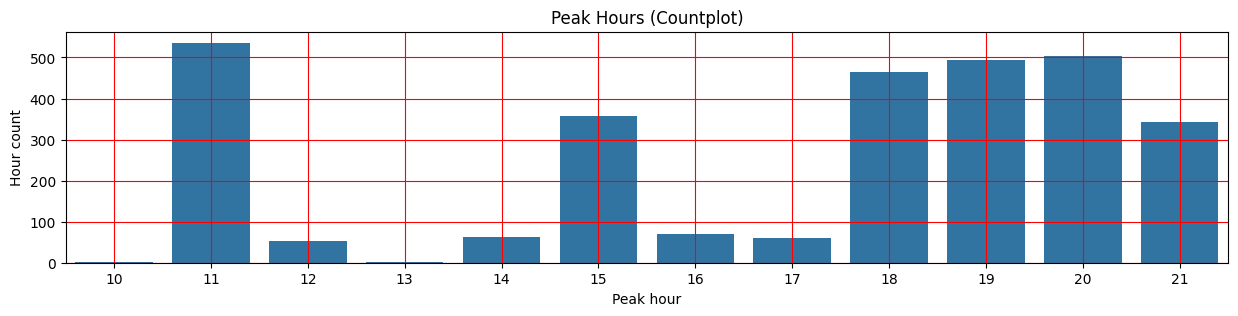

In [12]:
plt.figure(figsize=(15, 3))
sns.countplot(x="peak_hour", data=analyt_df)
plt.xlabel("Peak hour")
plt.ylabel("Hour count")
plt.title("Peak Hours (Countplot)")
plt.grid(color='r', linestyle='-');

Does target has a normal distribution?

In [13]:
print("Answer:", str(shapiro(analyt_df["peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

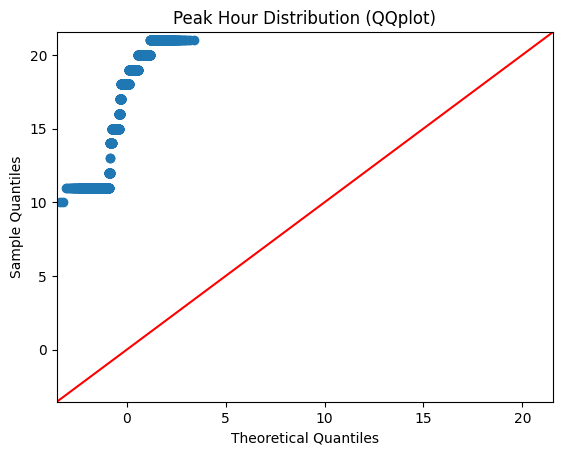

In [14]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["peak_hour"], line="45")
plt.title("Peak Hour Distribution (QQplot)");

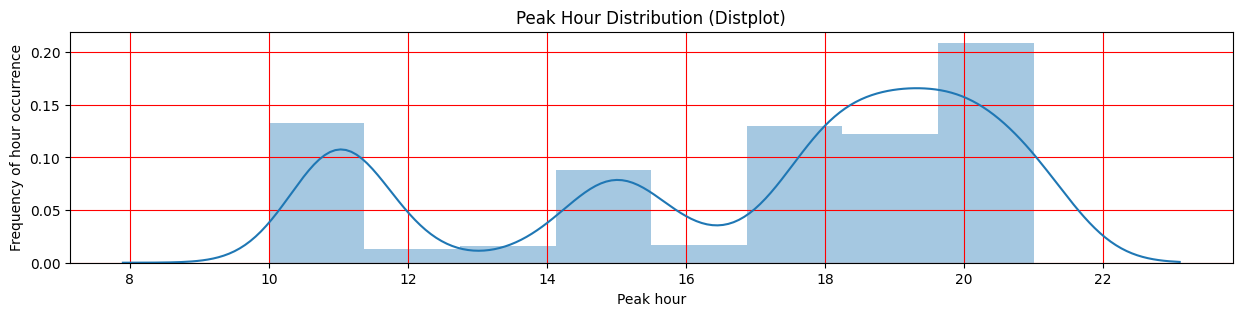

In [15]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["peak_hour"], bins=8, hist=True)
plt.xlabel("Peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

Obviously, the target distribution is not normal.

________________________________________________________________________________________________________________________________________________________

* Target trend:

In [16]:
analyt_df = df["2012-08":].copy()

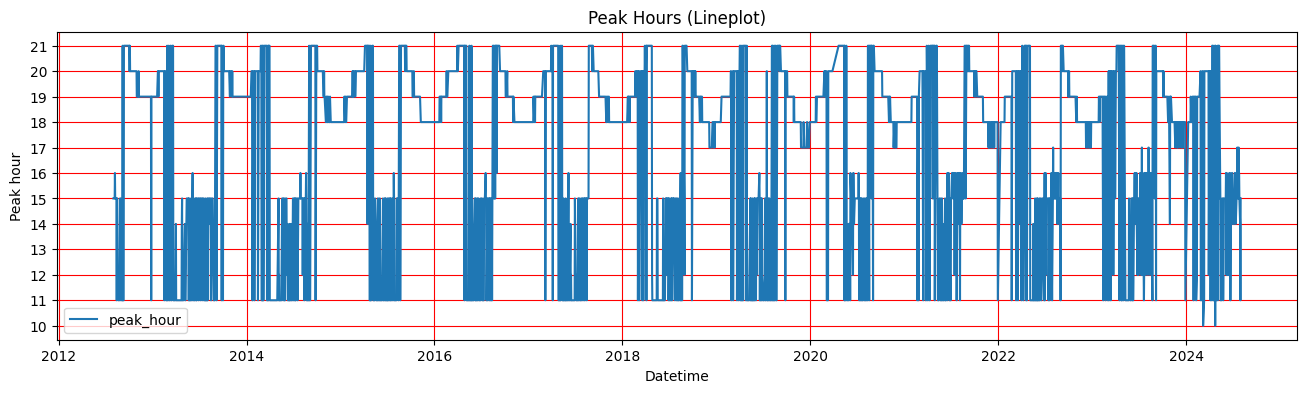

In [17]:
plt.figure(figsize=(16, 4))
figure = sns.lineplot(analyt_df)
figure.set_yticks([_ for _ in range(10, 22)])
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [18]:
get_average_months_length(df, 2013, 2023)

22

In [19]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "peak_hour", "mean", get_average_months_length(analyt_df, 2013, 2023) * 6)
).trend + ".")

Answer: increasing.


Visualise our suggest:

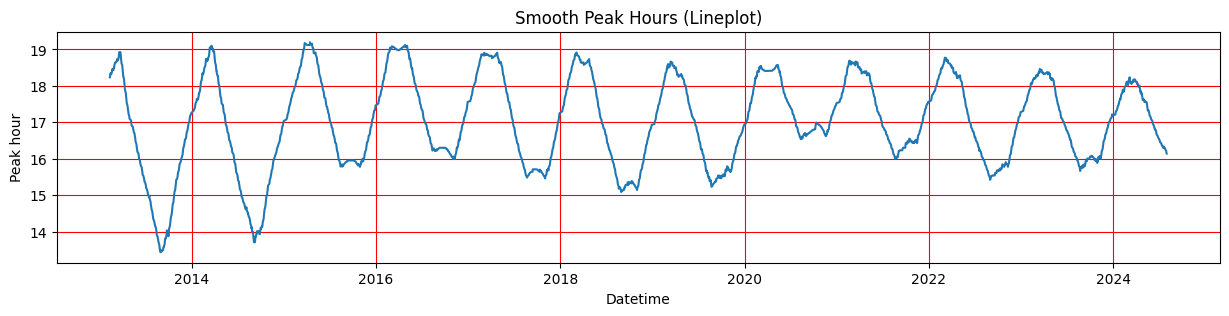

In [20]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    create_rolling_window_feature(analyt_df, "peak_hour", "mean", get_average_months_length(analyt_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [21]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "peak_hour", "mean",
                                                                       get_average_months_length(analyt_df, 2013, 2023)
                                                                       * 6)

analyt_df.dropna(inplace=True)

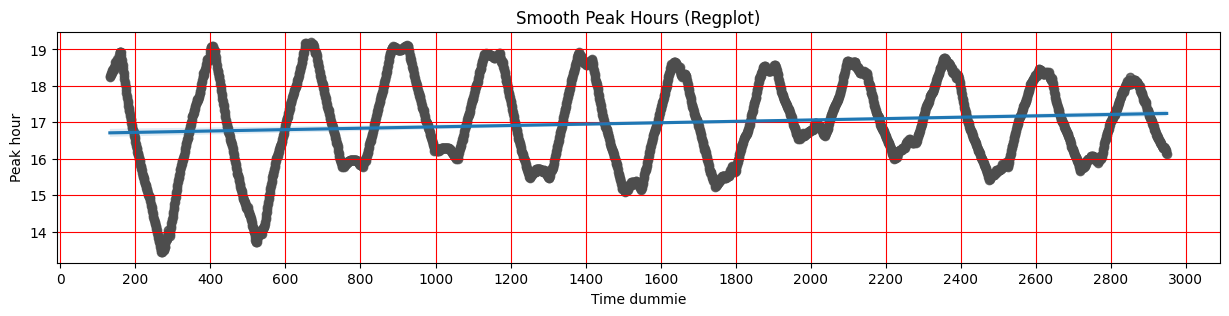

In [22]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(0, 3050, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a fake trend and a big dispersion.

Let's see plot without the first part of the target to be sure that we don't have a generally trend:

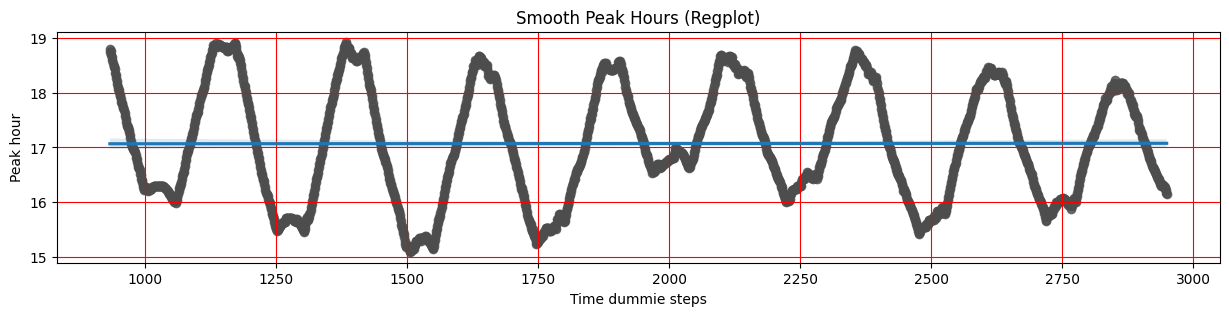

In [23]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df.iloc[800:], scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

And check the first part of the target to see trend:

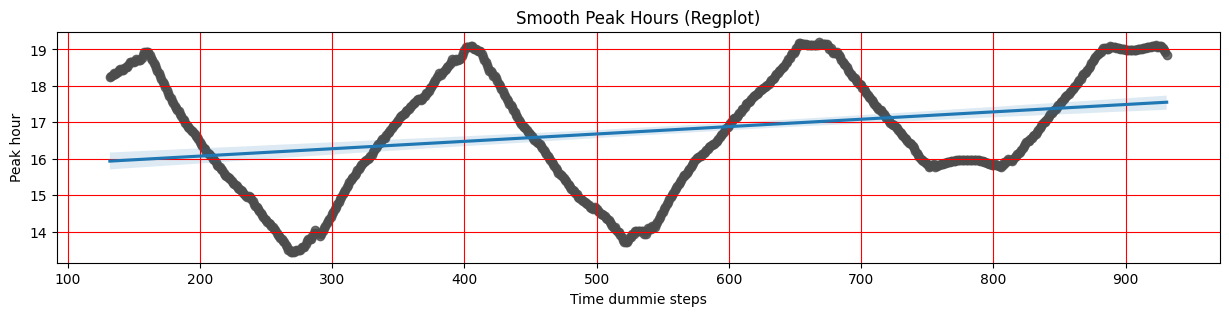

In [24]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df.iloc[: 800], scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The trend exists only in part of the data.

It means that we need to normalised target.

_________________________________________________________________________________________________________________________________________________________

* Target normalization:

In [25]:
featured_df = df.copy()

We will use a moved windows for the target normalization and forecasting.

The size of the step - 1 day.

In [26]:
featured_df = normalization(featured_df, "peak_hour")

In [27]:
featured_df.head(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2012-04-02,11,NaN,NaN,NaN
2012-04-03,11,NaN,NaN,NaN


In [28]:
featured_df.tail(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2024-07-30,11,2.228843,14.666667,-1.645099
2024-07-31,15,2.228843,14.666667,0.149554


We can have infinity and missing values after normalization in target.

In [29]:
featured_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3033 entries, 2012-04-02 to 2024-07-31
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   peak_hour             3033 non-null   int64  
 1   std_normalization     2970 non-null   float64
 2   mean_normalization    2970 non-null   float64
 3   normalized_peak_hour  2970 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 183.0 KB


In [30]:
featured_df[featured_df["normalized_peak_hour"].isna()].index.values[: 15]

array(['2012-04-02T00:00:00.000000000', '2012-04-03T00:00:00.000000000',
       '2012-04-04T00:00:00.000000000', '2012-04-05T00:00:00.000000000',
       '2012-04-06T00:00:00.000000000', '2012-04-09T00:00:00.000000000',
       '2012-04-10T00:00:00.000000000', '2012-04-11T00:00:00.000000000',
       '2012-04-12T00:00:00.000000000', '2012-04-13T00:00:00.000000000',
       '2012-04-16T00:00:00.000000000', '2012-04-17T00:00:00.000000000',
       '2012-04-18T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2012-04-20T00:00:00.000000000'], dtype='datetime64[ns]')

As we can see we have missing target only at the beginning of data.

This is because we use moving average window, it's ok.

How many infinity values do we have in the data?

In [31]:
print("Answer:", str(sum(featured_df["normalized_peak_hour"].apply(isinf))) + '.')

Answer: 0.


The last one, let's check up our normalized target:

In [32]:
featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [33]:
featured_df["mean"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean", 22)

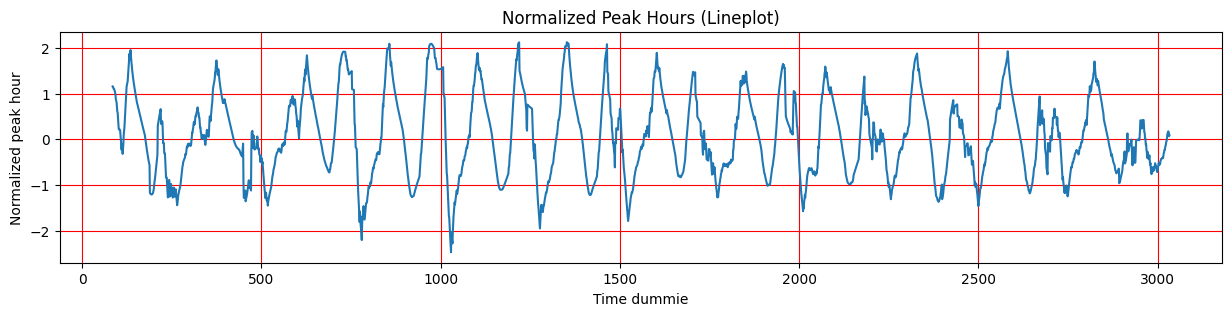

In [34]:
plt.figure(figsize=(15, 3))
sns.lineplot(data=featured_df, x="time_dummie", y="mean")
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

In [35]:
dsa

NameError: name 'dsa' is not defined

In [ ]:
featured_df["normalized_peak_hour"].describe()

1) We have the significant deviation of the target - 2023 % of the average value
2) Many target values are in the first quartile
3) Few target values are in the third quartile
4) The minium target value is smaller in 4.35 times than the maximum target valu

Df doesn't have missing and infinity target values, but it has outliers.

________________________________________________________________________________________________________________________________________________________

* Normalized target distribution:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

Does the normalized target has a normal distribution?

In [ ]:
print("Answer:", str(shapiro(analyt_df["normalized_peak_hour"])[1] > 0.05) + '.')

Visualise our suggest:

In [ ]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["normalized_peak_hour"], line="45")
plt.title("Normalized Peak Hour Distribution (QQplot)");

In [ ]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Normalized peak hour")
plt.ylabel("Frequency of occurrence")
plt.title("Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The target distribution is not normal, but is close to normal.

_________________________________________________________________________________________________________________________________________________________

* Normalized target trend:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

In [ ]:
plt.figure(figsize=(15, 3))
sns.lineplot(analyt_df)
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does the normalized target has a trend?

In [ ]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean", get_average_months_length(analyt_df, 2013,
                                                                                                       2023) * 6)).trend + ".")

Visualise our suggest:

In [ ]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2013, 2023) * 6)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 3000, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The normalized target has a trend.

_________________________________________________________________________________________________________________________________________________________

* The normalized target trend model:

The normalized target has a decreasing trend.

Let's cut a data from beginning, because we have leap at the first time.

This leap is exists because in 2014 year was a political problems which effect on economic and electro consumption.

Let's watch trend plots with difference windows size:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["quarter_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                    get_average_months_length(analyt_df, 2015,
                                                                                              2023) * 3)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="quarter_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [ ]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [ ]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["annual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                   get_average_months_length(analyt_df, 2015,
                                                                                             2023) * 12)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Definitely, we have the linear trend.

At first, delete target data before `2014-04`:

In [ ]:
featured_df = featured_df["2014-04":]

Let's create a trend model:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().dropna().to_frame()

In [ ]:
y = analyt_df["normalized_peak_hour"]

In [ ]:
y.head(2)

In [ ]:
y.tail(2)

In [ ]:
dp = DP(index=y.index, order=1)
x = dp.in_sample()

In [ ]:
x.head(2)

In [ ]:
x.tail(2)

In [ ]:
trend_model = LinRegr()

In [ ]:
trend_model.fit(x, y)

We will make prediction to subtract trend from trend (detrending):

In [ ]:
y_pred = pd.Series(trend_model.predict(x), index=x.index)

Let's detrending our time series:

In [ ]:
featured_df["normalized_peak_hour"] = featured_df["normalized_peak_hour"] - y_pred

And check up updated normalized target:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(100, 2350, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Detrending works.

Let's save our trend model:

In [ ]:
model_name = "trend_model.sav"
model_path = "../../../models/Московская область/"

In [ ]:
dump(trend_model, open(model_path + model_name, "wb"))

So let's check up the updated target data:

In [ ]:
featured_df["normalized_peak_hour"].to_frame().info()

In [ ]:
featured_df["normalized_peak_hour"].to_frame().describe()

Most of the data is biased in the negative direction.

________________________________________________________________________________________________________________________________________________________

* Detrended normalized target distribution:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

Does the detrended normalized target has a normal distribution?

In [ ]:
print("Answer:", str(shapiro(analyt_df["normalized_peak_hour"])[1] > 0.05) + '.')

Visualise our suggest:

In [ ]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["normalized_peak_hour"], line="45")
plt.title("Detrended Normalized Peak Hour Distribution (QQplot)");

In [ ]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Detrended normalized peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Detrended Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The distribution is still not normal.

________________________________________________________________________________________________________________________________________________________

* The detrended normalized target trend:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.lineplot(analyt_df["normalized_peak_hour"])
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [ ]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean", get_average_months_length(analyt_df, 2015,
                                                                                                       2023) * 6)).trend + ".")

Visualise our suggest:

In [ ]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_df, 2015, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(50, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [ ]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["annual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                   get_average_months_length(analyt_df, 2015,
                                                                                             2023) * 12)

analyt_df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a very little trend.

It will be better to ignore it.

_________________________________________________________________________________________________________________________________________________________

* The detrended normalized target periods:

In [ ]:
zxc_index = featured_df["normalized_peak_hour"]
freq = 245

In [ ]:
time = np.arange(len(zxc_index), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    zxc = pd.DataFrame(features, index=zxc_index)

In [ ]:
# plot_periodogram(featured_df["peak_hour"]["2015": ])

In [ ]:
plot_periodogram(featured_df["normalized_peak_hour"])

In [ ]:
sm = 0
cnt = 0

for year in range(2015, 2023):
    sm += analyt_df[analyt_df.index.year == year].shape[0]
    cnt += 1

year_days_count = sm / cnt

In [ ]:
# X = analyt_df["normalized_peak_hour"].copy().to_frame()
# X["day"] = X.index.dayofweek + 1
# X["week"] = X.index.isocalendar().week
# X["dayofyear"] = X.index.dayofyear
# X["year"] = X.index.year

In [ ]:
# seasonal_plot(X["2019-04": "2020-04"], y="normalized_peak_hour", period="week", freq="day")

паттерна нет

In [ ]:
# seasonal_plot(X, y="normalized_peak_hour", period="year", freq="dayofyear");

есть паттерн годовой

Год, пол года, квартал, 5 месяцев

Недельной нет.

In [ ]:
days = np.arange(len(featured_df["normalized_peak_hour"])) + 1

In [ ]:
# # res1 = create_fourier_features(days, year_days_count)
# # res2 = create_fourier_features(days, (year_days_count + 1) // 2)
# # res3 = create_fourier_features(days, (year_days_count + 1) // 5)

# year_sin = pd.Series(np.sin(2 * np.pi * days / 247 * 2.02))
# year_cos = pd.Series(np.cos(2 * np.pi * days / 247 * 2.02))

# res = pd.concat({"year_cos": year_cos, "year_sin": year_sin}, axis=1)

# # res = pd.concat([res1, res2, res3], axis=1)

In [ ]:
season_model = LinRegr(fit_intercept=False)
_ = season_model.fit(zxc, featured_df["normalized_peak_hour"])

In [ ]:
y_pred = pd.Series(season_model.predict(zxc), index=featured_df["normalized_peak_hour"].index)

In [ ]:
y_pred

In [ ]:
plot_periodogram(featured_df["normalized_peak_hour"] - y_pred)

In [ ]:
featured_df["normalized_peak_hour"] = featured_df["normalized_peak_hour"] - y_pred

In [ ]:
model_name = "season_model.sav"
model_path = "../../../models/Московская область/"
dump(trend_model, open(model_path + model_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

* Check normalize target correlation:

In [ ]:
analyt_df = featured_df["normalized_peak_hour"].copy().dropna().to_frame()

In [ ]:
# print("Does normalized data a autocorrelation?")
# print("Answer:", f'{max(sm.tsa.acf(analyt_df["normalized_peak_hour"])[1:]) > 0.4}.')
# print("Visualise our suggest.")

In [ ]:
plt.figure(figsize=(20, 4))
autocorr_plot(analyt_df["normalized_peak_hour"], lags=get_average_months_length(analyt_df, 2015, 2023) * 12)
plt.axis("tight")
plt.ylabel("Correlation coefficient", fontsize=14)
plt.xlabel("The order of the peak hour", fontsize=14)
plt.title("Peak hour autocorrelation", fontsize=16)
plt.show();

In [ ]:
print("Let's see a separated cases:")

In [ ]:
# analyt_df["day_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 1)
# analyt_df["week_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 5)
# analyt_df["two_weeks_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 10)

In [ ]:
# plt.figure(figsize=(20, 4))
# fig, ax = plt.subplots()
# ax = sns.regplot(x="day_lag", y="normalized_peak_hour", data=analyt_df.dropna(), ci=None,
#                  scatter_kws=dict(color="0.25"))
# ax.set_aspect("equal")
# plt.ylabel("Current normalized peak hour", fontsize=14)
# plt.xlabel("Day lag normalized peak hour", fontsize=14)
# ax.set_title("Lag plot of normalized peak hour")

In [ ]:
# plt.figure(figsize=(20, 4))
# autocorr_plot(analyt_df["normalized_peak_hour"], lags=get_average_months_length(analyt_df, 2012, 2023) * 30)
# plt.axis("tight")
# plt.ylabel("Correlation coefficient", fontsize=14)
# plt.xlabel("The order of the peak hour", fontsize=14)
# plt.title("Autocorrelation", fontsize=16)
# plt.show();

In [ ]:
# print("There is a strong changing correlation.")

In [ ]:
featured_df["lag_1"] = create_lag_feature(featured_df, "normalized_peak_hour", 1)
featured_df["lag_2"] = create_lag_feature(featured_df, "normalized_peak_hour", 2)
featured_df["lag_5"] = create_lag_feature(featured_df, "normalized_peak_hour", 5)
featured_df["lag_7"] = create_lag_feature(featured_df, "normalized_peak_hour", 7)
featured_df["lag_10"] = create_lag_feature(featured_df, "normalized_peak_hour", 10)
featured_df["lag_28"] = create_lag_feature(featured_df, "normalized_peak_hour", 28)
featured_df["lag_59"] = create_lag_feature(featured_df, "normalized_peak_hour", 59)
featured_df["lag_245"] = create_lag_feature(featured_df, "normalized_peak_hour", 245)
featured_df["lag_247"] = create_lag_feature(featured_df, "normalized_peak_hour", 247)

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH FEATURES

* TIME DUMMIE FEATURE

In [ ]:
# featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [ ]:
# featured_df.head(2)

In [ ]:
# featured_df.tail(2)

* DATETIME FEATURE

In [ ]:
# featured_df = pd.concat([featured_df, create_dayofweek_features(featured_df)[
#     ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday"]]],
#                         axis=1)

In [ ]:
# featured_df.head(2)

In [ ]:
featured_df["day_of_month"] = featured_df.index.day
featured_df["day_of_year"] = featured_df.index.dayofyear
featured_df["week_of_year"] = featured_df.index.isocalendar().week
featured_df["month"] = featured_df.index.month
featured_df["quarter"] = featured_df.index.quarter
featured_df["year"] = featured_df.index.year

In [ ]:
# featured_df.head(2)

* HOLIDAYS FEATURE

In [ ]:
# print("Current dataframe has a holidays?", f"Answer: {sum(create_holiday_feature(df)) > 0}.")

* ROLLING MEAN WINDOW FEATURES

In [ ]:
# featured_df["rolling_mean_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean", 5).shift(
#     1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.title("Mean week")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean",
#                                                                   get_average_months_length(featured_df, 2012,
#                                                                                             2023)).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_month")
# plt.title("Mean month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_quarter")
# plt.title("Mean quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_semiannual")
# plt.title("Mean semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_annual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 12
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_annual")
# plt.title("Mean annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_quinquennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 60
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_quinquennial")
# plt.title("Mean quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_mean_decennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 120
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_decennial")
# plt.title("Mean decennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MEDIAN WINDOW FEATURES

In [ ]:
# featured_df["rolling_median_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "median",
#                                                                    5).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_week")
# plt.title("Median week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_median_month"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023)
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_month")
# plt.title("Median month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_median_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_quarter")
# plt.title("Median quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_median_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_semiannual")
# plt.title("Median semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MAX WINDOW FEATURES

In [ ]:
# featured_df["rolling_max_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "max", 5).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_week")
# plt.title("Max week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_max_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "max",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_month")
# plt.title("Max month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_max_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "max",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_quarter")
# plt.title("Max quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MIN WINDOW FEATURES

In [ ]:
# featured_df["rolling_min_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "min", 5).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_week")
# plt.title("Min week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_min_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "min",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_month")
# plt.title("Min month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_min_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "min",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_quarter")
# plt.title("Min quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING STD WINDOW FEATURES

In [ ]:
# featured_df["rolling_std_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "std", 5).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_week")
# plt.title("Std week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_std_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "std",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_month")
# plt.title("Std month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_std_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_quarter")
# plt.title("Std quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_std_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_semiannual")
# plt.title("Std semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_std_annual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 12
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_annual")
# plt.title("Std annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [ ]:
# featured_df["rolling_std_quinquennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 60
# ).shift(1)

In [ ]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_quinquennial")
# plt.title("Std quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH LAG FEATURES

In [ ]:
# featured_df

In [ ]:
# featured_df["day_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 1)
# featured_df["week_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 5)
# featured_df["month_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 25)
# featured_df["quarter_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 75)
# featured_df["half_year_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 120)
# featured_df["year_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 240)

________________________________________________________________________________________________________________________________________________________

In [ ]:
# featured_df

MAKE PREDICTIONS:

In [ ]:
# featured_df = featured_df.drop("time_dummie", axis=1)

In [ ]:
# featured_df

In [ ]:
# std_norm = featured_df["std_norm"]
# mean_norm = featured_df["mean_norm"]

In [ ]:
featured_df.columns

In [ ]:
featured_df.dropna(inplace=True)

In [ ]:
featured_df

In [ ]:
featured_df.to_parquet("../../model_development/feature_data.gzip")

In [ ]:
zxc = featured_df.copy()

In [ ]:
y = featured_df["normalized_peak_hour"].copy()

In [ ]:
featured_df = featured_df.drop(
    columns=["peak_hour", "std_normalization", "mean_normalization", "time_dummie"], axis=1)

In [ ]:
featured_df

In [ ]:
# true_val = featured_df["peak_hour"]

In [ ]:
# featured_df.drop(columns=["peak_hour"], axis=1, inplace=True)

In [ ]:
# featured_df

In [ ]:
# featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [ ]:
featured_df.info()

In [ ]:
featured_df.drop(columns=["normalized_peak_hour"], inplace=True)

In [ ]:
train_x = featured_df[: 1900]
test_x = featured_df[1900:]

In [ ]:
train_y = y[: 1900]
test_y = y[1900:]

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(n_estimators=100, max_depth=3)

In [ ]:
# help(model)

In [ ]:
# help(model.fit)

In [ ]:
model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], eval_metric="mae", verbose=10,
          early_stopping_rounds=6)

In [ ]:
data = pd.concat([train_x, test_x], axis=0)

In [ ]:
target = pd.concat([train_y, test_y], axis=0)

In [ ]:
# model.fit(data, target)

In [ ]:
import pickle

In [ ]:
file_name = "xgb_reg.pkl"

pickle.dump(model, open(model_path + file_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

In [ ]:
zxc_index = zxc
freq = 245

time = np.arange(len(zxc), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    sincos = pd.DataFrame(features, index=zxc_index)

In [ ]:
sincos.index = zxc.index

In [ ]:
zxc = pd.concat([zxc, sincos], axis=1)

In [ ]:
dp = DP(index=zxc.index, order=1)

In [ ]:
zxc["trend"] = dp.in_sample()

In [ ]:
zxc["trend"] += 2537 - 2290

In [ ]:
pred = model.predict(zxc[model.feature_names_in_])

In [ ]:
pred = pred + season_model.predict(zxc[season_model.feature_names_in_])

In [ ]:
pred = pred + trend_model.predict(zxc[trend_model.feature_names_in_])

In [ ]:
res = pred * zxc["std_normalization"] + zxc["mean_normalization"]

In [ ]:
import datetime

In [ ]:
model.feature_names_in_

In [ ]:
main_df

In [ ]:
dd = 1
lst = [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30]

freq = 245

In [ ]:
for _ in range(31):
    new_df = main_df.copy()

    if (new_df.index[-1] + datetime.timedelta(days=dd)).day not in lst:
        dd += 1
        continue
    else:
        day_node = new_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        new_df = pd.concat([new_df, day_node], axis=0)
        # С НОВЫМ ДНЁМ DF

        new_df["day_of_month"] = new_df.index.day

        new_df = normalization(new_df, "peak_hour")
        # НСРМАЛИЗОВАННЫЙ DF

        new_df = new_df["2014-04":]

        dp = DP(index=new_df.index, order=1)
        x = dp.in_sample()
        new_df["trend"] = x

        y_pred = pd.Series(trend_model.predict(x), index=new_df.index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] - y_pred
        # Detrended

        indx = new_df["normalized_peak_hour"]
        freq = 245

        time = np.arange(len(indx), dtype=np.float32)
        k = 2 * np.pi * (1 / freq) * time
        features = {}

        for i in [1, 2, 5]:
            features.update({
                f"sin_{freq}_{i}": np.sin(i * k),
                f"cos_{freq}_{i}": np.cos(i * k),
            })

        fourier_features = pd.DataFrame(features, index=indx)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_df["normalized_peak_hour"].index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] - y_pred

        new_df["lag_1"] = create_lag_feature(new_df, "normalized_peak_hour", 1)
        new_df["lag_2"] = create_lag_feature(new_df, "normalized_peak_hour", 2)
        new_df["lag_5"] = create_lag_feature(new_df, "normalized_peak_hour", 5)
        new_df["lag_7"] = create_lag_feature(new_df, "normalized_peak_hour", 7)
        new_df["lag_10"] = create_lag_feature(new_df, "normalized_peak_hour", 10)
        new_df["lag_28"] = create_lag_feature(new_df, "normalized_peak_hour", 28)
        new_df["lag_59"] = create_lag_feature(new_df, "normalized_peak_hour", 59)
        new_df["lag_245"] = create_lag_feature(new_df, "normalized_peak_hour", 245)
        new_df["lag_247"] = create_lag_feature(new_df, "normalized_peak_hour", 247)

        new_df["day_of_month"] = new_df.index.day
        new_df["day_of_year"] = new_df.index.dayofyear
        new_df["week_of_year"] = new_df.index.isocalendar().week
        new_df["month"] = new_df.index.month
        new_df["quarter"] = new_df.index.quarter
        new_df["year"] = new_df.index.year

        new_df["normalized_peak_hour"] = pd.Series(model.predict(new_df[model.feature_names_in_]), index=new_df.index)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_df["normalized_peak_hour"].index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] + y_pred

        y_pred = pd.Series(trend_model.predict(x), index=new_df.index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] + y_pred

        new_df["peak_hour"] = new_df["normalized_peak_hour"] * new_df["std_normalization"] + new_df[
            "mean_normalization"]

        day_node = main_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        main_df = pd.concat([main_df, day_node], axis=0)
        main_df["peak_hour"][-1] = round(new_df["peak_hour"][-1])
        dd = 1

In [ ]:
new_df["2024-08":]